# Sex and Age Data

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census 
from us import states 
import contextily as ctx

In [2]:
from Globals import CENSUS_KEY

In [3]:
# Set API key
c = Census(CENSUS_KEY)

## Variables

In [4]:
# Grabbing a few variables of interest pertaining to the economic vitality of an area
fields = {
    "NAME" : "Name"
    , "B01003_001E" : "Total Population"
    , "B01001_002E" : "Male"
    , "B01001_026E" : "Female"
    , "B01002_001E" : "Median Age"
    , "B01002_002E" : "Med Age Male"
    , "B01002_003E" : "Med Age Female"
}

## Download three years

In [5]:
def nm_dl(year):
    data = c.acs5.state_county_tract(
        fields = list(fields.keys()),
        state_fips = states.NM.fips,
        county_fips = "*",
        tract = "*",
        year = year
        )
    return data

In [6]:
nm_demo_2022_df = pd.DataFrame(nm_dl(2022))
nm_demo_2019_df = pd.DataFrame(nm_dl(2019))
nm_demo_2016_df = pd.DataFrame(nm_dl(2016))

In [7]:
for df in [nm_demo_2022_df, nm_demo_2019_df, nm_demo_2016_df]: 
    df.rename(columns=fields, inplace=True)

## Download geometries and merge

In [8]:
nm_tract_2022 = gpd.read_file('../../../localData/Census/nm_tract_2022.gpkg').to_crs(epsg = 32113)[['GEOID', 'geometry']]
nm_tract_2019 = gpd.read_file('../../../localData/Census/nm_tract_2019.gpkg').to_crs(epsg = 32113)[['GEOID', 'geometry']]
nm_tract_2016 = gpd.read_file('../../../localData/Census/nm_tract_2016.gpkg').to_crs(epsg = 32113)[['GEOID', 'geometry']]

In [9]:
for df in [nm_demo_2016_df, nm_demo_2019_df, nm_demo_2022_df]: 
    df['GEOID'] = (df.state + df.county + df.tract)

In [10]:
nm_demo_2022 = nm_tract_2022.merge(nm_demo_2022_df, on='GEOID')
nm_demo_2019 = nm_tract_2019.merge(nm_demo_2019_df, on='GEOID')
nm_demo_2016 = nm_tract_2016.merge(nm_demo_2016_df, on='GEOID')

In [11]:
nm_demo_2022.describe()

,Total Population,Male,Female,Median Age,Med Age Male,Med Age Female
count,612.000000,612.000000,612.000000,6.120000e+02,6.120000e+02,6.120000e+02
mean,3451.736928,1720.356209,1731.380719,-1.198253e+07,-1.198253e+07,-1.307185e+07
std,1607.911533,820.346349,825.507890,8.864332e+07,8.864332e+07,9.250787e+07
min,0.000000,0.000000,0.000000,-6.666667e+08,-6.666667e+08,-6.666667e+08
25%,2336.750000,1131.250000,1154.250000,3.330000e+01,3.182500e+01,3.420000e+01
50%,3270.000000,1630.000000,1636.500000,3.875000e+01,3.775000e+01,4.020000e+01
75%,4342.750000,2153.500000,2159.750000,4.540000e+01,4.482500e+01,4.730000e+01
max,11590.000000,6121.000000,5469.000000,8.410000e+01,8.180000e+01,8.510000e+01


In [12]:
for df in [nm_demo_2016, nm_demo_2019, nm_demo_2022]:
    for col in ['Median Age', 'Med Age Male', 'Med Age Female']:
        df.loc[df[col] < 0, col] = 0

In [13]:
nm_demo_2019.describe()

,Total Population,Male,Female,Median Age,Med Age Male,Med Age Female
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,4193.294589,2076.533066,2116.761523,39.643287,38.420842,40.858116
std,2001.968807,988.898814,1043.614689,8.913656,9.256295,9.373968
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2787.500000,1387.500000,1371.500000,33.750000,32.200000,34.300000
50%,3993.000000,1948.000000,1991.000000,38.000000,36.900000,39.600000
75%,5260.000000,2622.000000,2677.000000,44.400000,43.600000,46.200000
max,16968.000000,6881.000000,10087.000000,80.000000,72.100000,80.600000


In [14]:
nm_demo_2022.to_file('../../../localData/Census/nm_age_sex_2022.gpkg', layer='Tract')
nm_demo_2019.to_file('../../../localData/Census/nm_age_sex_2019.gpkg', layer='Tract')
nm_demo_2016.to_file('../../../localData/Census/nm_age_sex_2016.gpkg', layer='Tract')

## Group by county and state

In [15]:
def to_county(df):
    (df.drop(columns=['Name','tract','state', 'GEOID'])
       .dissolve('county', aggfunc='sum')
       .reset_index())
    return df
def to_state(df):
    (df.drop(columns=['Name','tract','county', 'GEOID'])
       .dissolve('state', aggfunc='sum')
       .reset_index())
    return df

In [16]:
(to_county(nm_demo_2022)
 .to_file('../../../localData/Census/nm_age_sex_2022.gpkg', layer='County'))
(to_county(nm_demo_2019)
 .to_file('../../../localData/Census/nm_age_sex_2019.gpkg', layer='County'))
(to_county(nm_demo_2016)
 .to_file('../../../localData/Census/nm_age_sex_2016.gpkg', layer='County'))
(to_state(nm_demo_2022)
 .to_file('../../../localData/Census/nm_age_sex_2022.gpkg', layer='State'))
(to_state(nm_demo_2019)
 .to_file('../../../localData/Census/nm_age_sex_2019.gpkg', layer='State'))
(to_state(nm_demo_2016)
 .to_file('../../../localData/Census/nm_age_sex_2016.gpkg', layer='State'))

## Clip Albuquerque and VTR by predefined shape

In [17]:
abq_shp = gpd.read_file('../../../data/local/abq_shp.gpkg').to_crs(nm_demo_2022.crs)
vtr_shp = gpd.read_file('../../../data/local/vtr_shp.gpkg').to_crs(nm_demo_2022.crs)

In [18]:
(nm_demo_2022.clip(abq_shp)
 .to_file('../../../localData/Census/nm_age_sex_2022.gpkg', layer='Albuquerque'))
(nm_demo_2019.clip(abq_shp)
 .to_file('../../../localData/Census/nm_age_sex_2019.gpkg', layer='Albuquerque'))
(nm_demo_2016.clip(abq_shp)
 .to_file('../../../localData/Census/nm_age_sex_2016.gpkg', layer='Albuquerque'))

In [19]:
(nm_demo_2022.clip(vtr_shp)
 .to_file('../../../localData/Census/nm_age_sex_2022.gpkg', layer='VTR'))
(nm_demo_2019.clip(vtr_shp)
 .to_file('../../../localData/Census/nm_age_sex_2019.gpkg', layer='VTR'))
(nm_demo_2016.clip(vtr_shp)
 .to_file('../../../localData/Census/nm_age_sex_2016.gpkg', layer='VTR'))

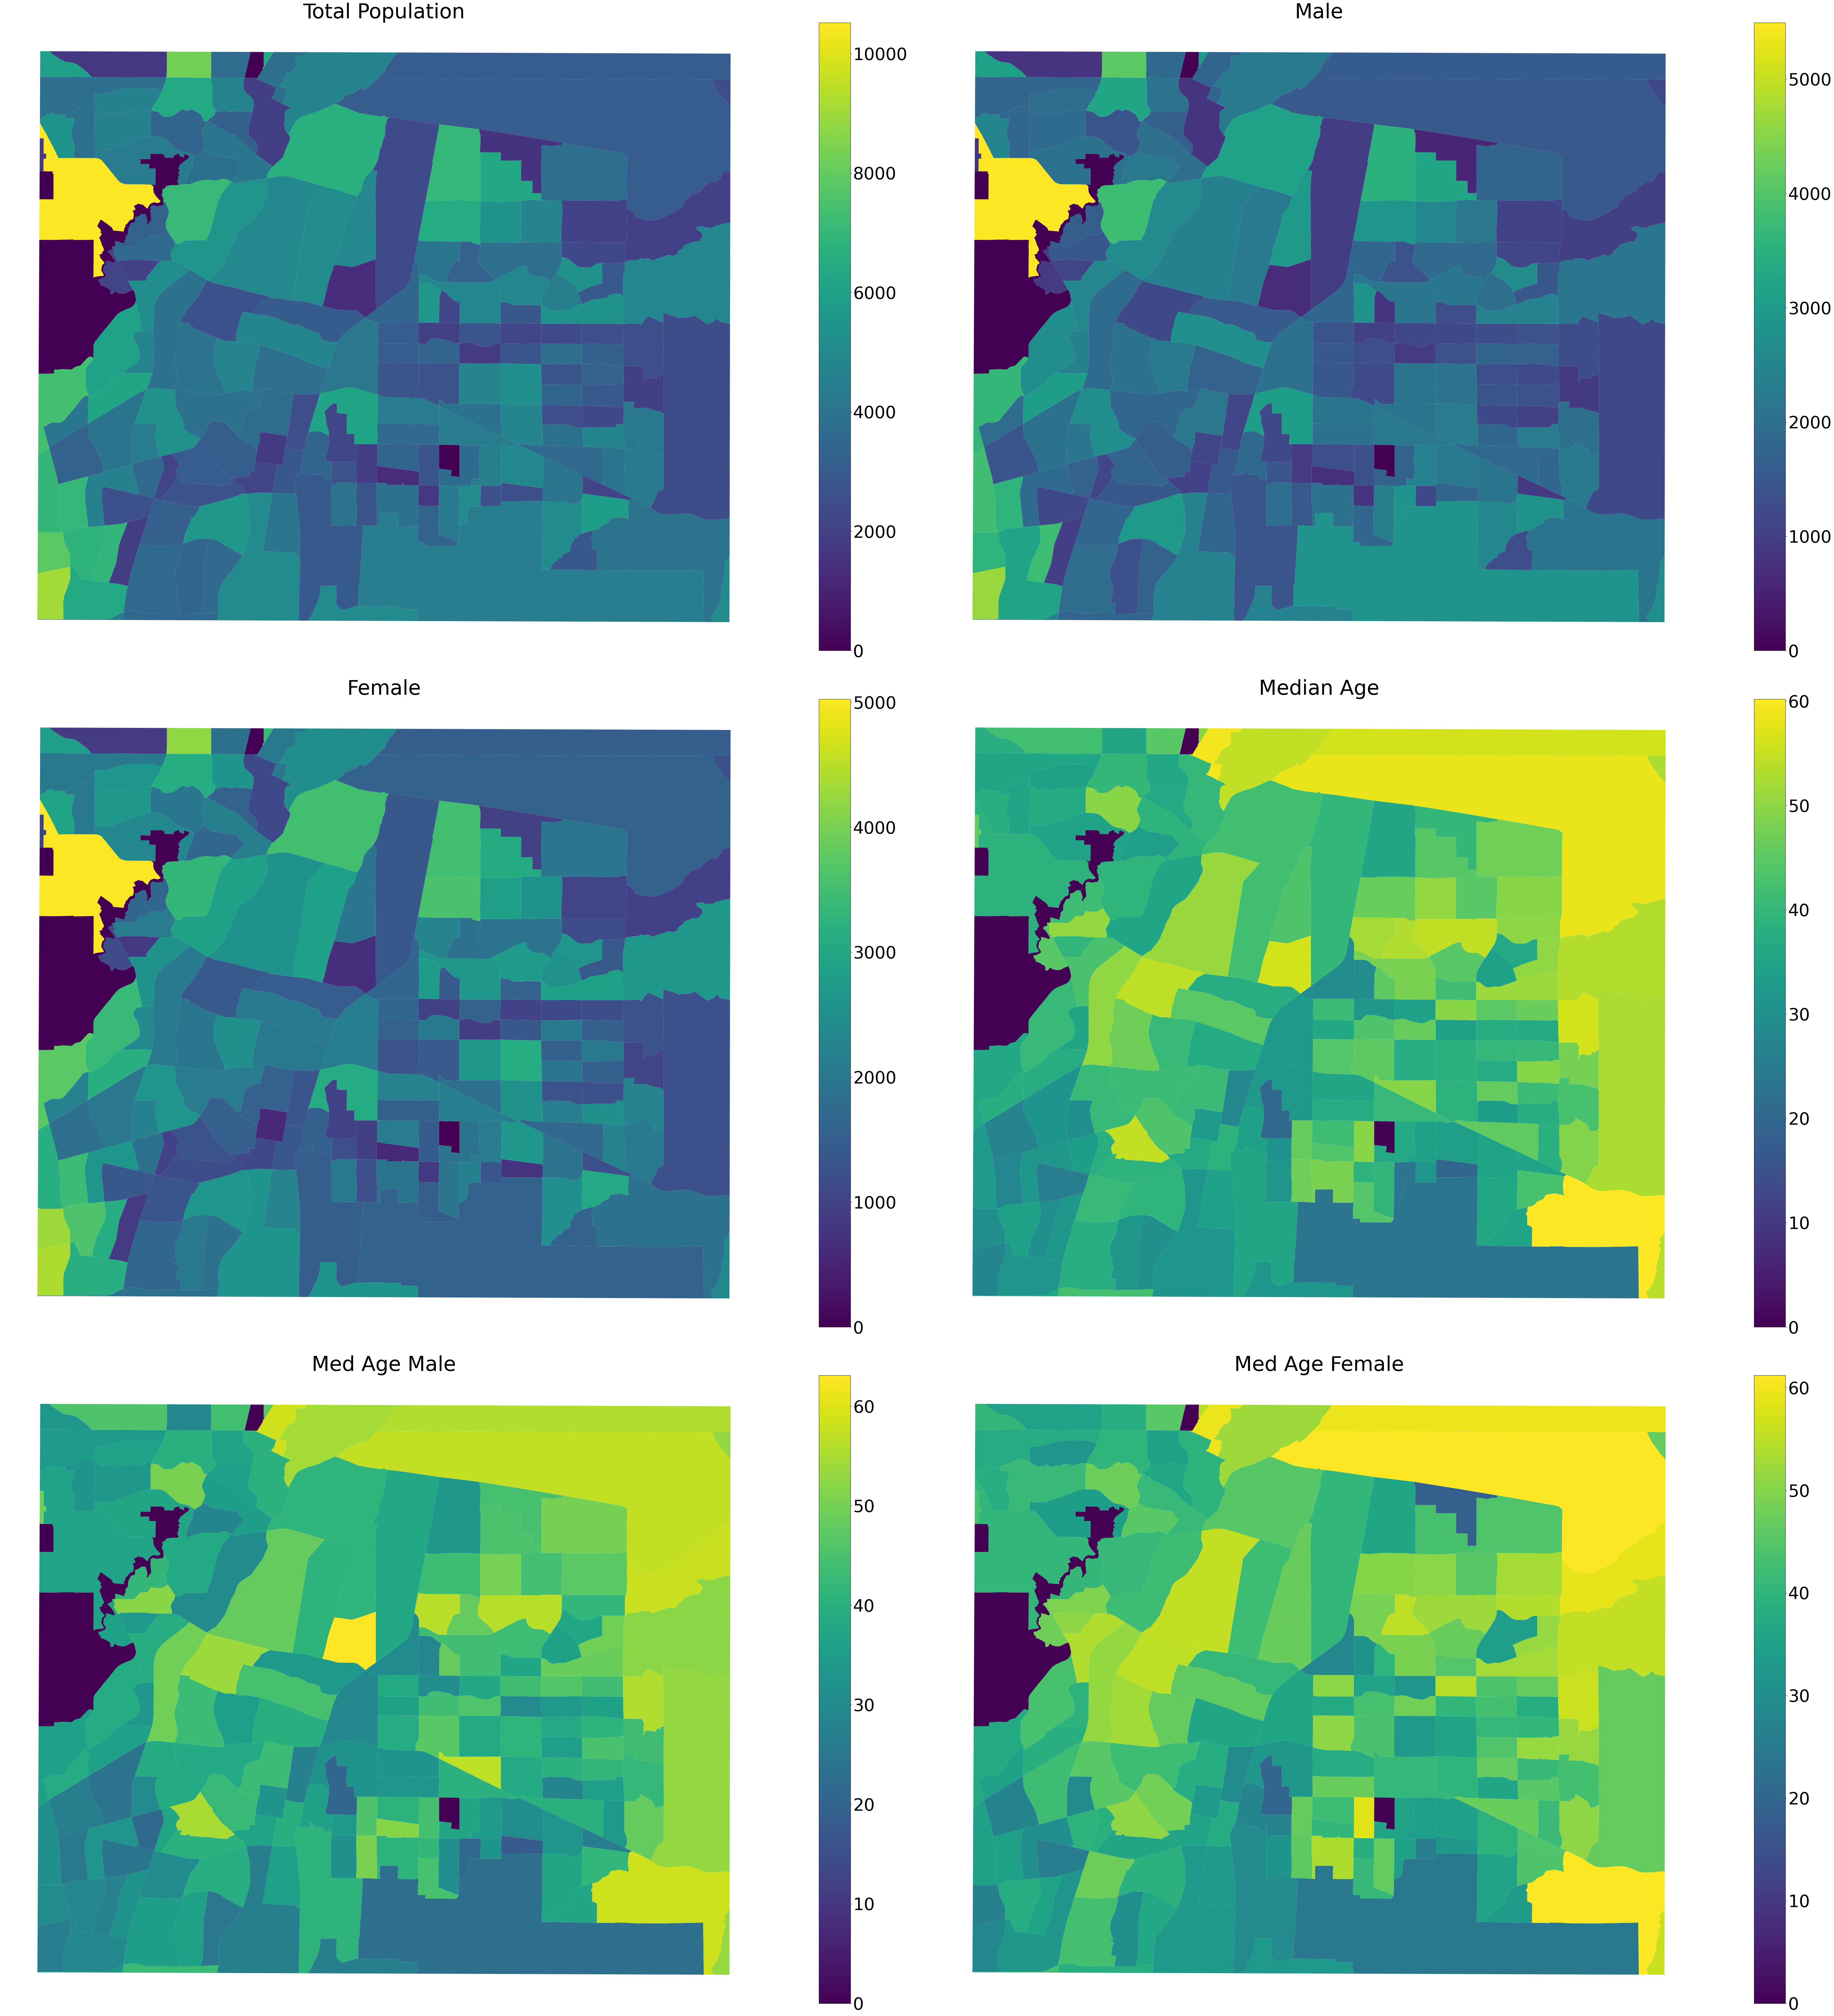

In [20]:
abq_2022 = gpd.read_file('../../../localData/Census/nm_age_sex_2022.gpkg',
                        layer='Albuquerque')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(75,75), layout='tight')

axes = axes.flatten()

# Setting the font size
plt.rcParams['font.size'] = '45'
plt.style.use('seaborn-v0_8-dark-palette')

# Plotting each of the extracted variables in a subplot
for ind, col in enumerate(list(fields.values())[1:]):
    ax = axes[ind]
    abq_2022.plot(column=col,
                  ax = ax
                  #, scheme = "quantiles"
                  , linewidth=0, cmap="viridis", 
                    legend=True
                  #, legend_kwds={'loc': 'center left','bbox_to_anchor':(1,0.5),'fmt': "{:.0f}"}
                 ) 
    ax.set_axis_off()
    ax.set_title(col)
plt.subplots_adjust(wspace=None, hspace=None)
plt.show()

## Get Country-wide data

In [48]:
us_demo_2022_dl = c.acs5.state_county(
    fields = list(fields.keys()),
    state_fips = "*",
    county_fips = "*",
    year = 2022
    )
us_demo_2019_dl = c.acs5.state_county(
    fields = list(fields.keys()),
    state_fips = "*",
    county_fips = "*",
    year = 2019
    )
us_demo_2016_dl = c.acs5.state_county(
    fields = list(fields.keys()),
    state_fips = "*",
    county_fips = "*",
    year = 2016
    )

In [49]:
us_demo_2022_df = pd.DataFrame(us_demo_2022_dl)
us_demo_2019_df = pd.DataFrame(us_demo_2019_dl)
us_demo_2016_df = pd.DataFrame(us_demo_2016_dl)

In [50]:
for df in [us_demo_2022_df, us_demo_2019_df, us_demo_2016_df]: 
    df.rename(columns=fields, inplace=True)

In [51]:
us_tract_2022 = gpd.read_file('../../../data/local/tl_2022_us_county.zip')[['GEOID', 'geometry']]
us_tract_2019 = gpd.read_file('../../../data/local/tl_2019_us_county.zip')[['GEOID', 'geometry']]
us_tract_2016 = gpd.read_file('../../../data/local/tl_2016_us_county.zip')[['GEOID', 'geometry']]

In [52]:
for df in [us_demo_2022_df, us_demo_2019_df, us_demo_2016_df]: 
    df['GEOID'] = (df.state + df.county)

In [53]:
us_demo_2022 = us_tract_2022.merge(us_demo_2022_df, on='GEOID')
us_demo_2019 = us_tract_2019.merge(us_demo_2019_df, on='GEOID')
us_demo_2016 = us_tract_2016.merge(us_demo_2016_df, on='GEOID')

In [54]:
us_demo_2022.to_file('../../../data/Census/us_age_sex_2022.gpkg')
us_demo_2019.to_file('../../../data/Census/us_age_sex_2019.gpkg')
us_demo_2016.to_file('../../../data/Census/us_age_sex_2016.gpkg')